## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [22]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [26]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
# Считаем размер эффекта -> https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки -> https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html?highlight=normalindpower
# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [11]:
df = pd.read_csv("ab_test_ensembles.csv")

# Первичный анализ
print(df.head())
print(df.info())
print(df.describe())
print(df['group'].value_counts())
print(df['variants'].value_counts())

                                user_id                   timestamp  \
0  9109b0dc-d393-497f-8d63-ba9a25dd16b4  2022-05-21 22:11:48.556739   
1  2430c3d2-f75b-4b31-8271-51b6a76c2652  2022-05-12 08:01:45.159739   
2  44788c4e-8dd2-4fad-b986-75e76f4adb64  2022-05-11 16:55:06.154213   
3  4699a417-506d-41b8-a354-6af6ad576963  2022-05-08 18:28:03.143765   
4  304b0d28-bcdf-401a-9dff-66230d3ba0bc  2022-05-21 01:52:26.210827   

       group             variants  converted        location age_group  \
0    control             standard          0  United Kingdom     18-25   
1    control             standard          0  United Kingdom     42-49   
2  treatment  svm_ensemble_v_1_22          0  United Kingdom     26-33   
3  treatment  svm_ensemble_v_1_22          0  United Kingdom     42-49   
4    control             standard          1  United Kingdom     42-49   

         user_type  
0  registered_user  
1  registered_user  
2         new_user  
3  registered_user  
4  registered_user  
<c

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [9]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Коэффициенты конверсии по группам:
 group      variants           
control    standard               0.120386
           svm_ensemble_v_1_22    0.121369
treatment  standard               0.127226
           svm_ensemble_v_1_22    0.118807
Name: converted, dtype: float64


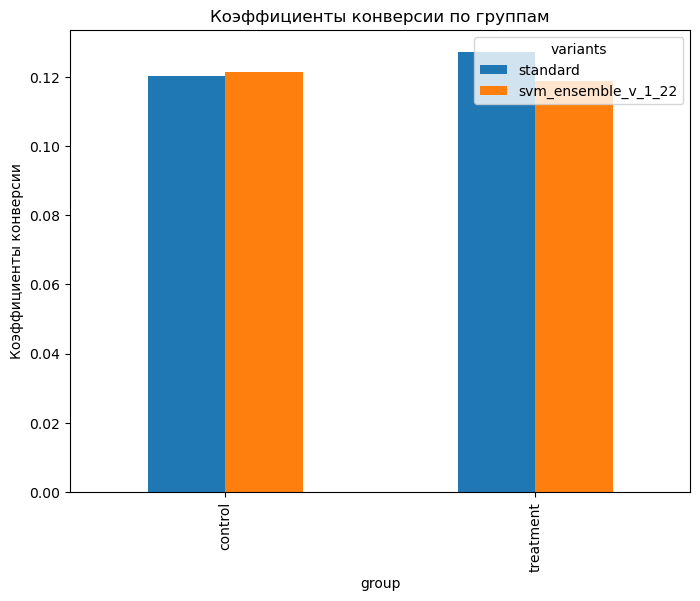

Распределение пользователей по типам:
 user_type
registered_user    147240
new_user           147238
Name: count, dtype: int64


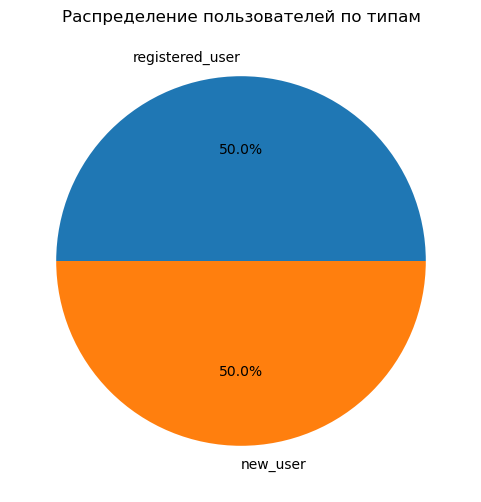

In [15]:
# по группам
conversion_rates = df.groupby(['group', 'variants'])['converted'].mean()
print("Коэффициенты конверсии по группам:\n", conversion_rates)

conversion_rates.unstack().plot(kind='bar', figsize=(8, 6), title='Коэффициенты конверсии по группам')
plt.ylabel('Коэффициенты конверсии')
plt.show()

# по типу
user_type_distribution = df['user_type'].value_counts()
print("Распределение пользователей по типам:\n", user_type_distribution)

user_type_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title='Распределение пользователей по типам')
plt.ylabel('')
plt.show()

Проверка гипотезы для всей выборки

In [32]:
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Новый вариант (treatment) не достиг улучшения на 2%.
Результат не является статистически значимым (p >= 0.05).

In [ ]:
Анализ по типу пользователей

In [38]:

# Известные типы пользователей
user_types = ['new_user', 'registered_user']

for user_type in user_types:
    user_data = df[df['user_type'] == user_type]
    control_results = user_data[user_data['group'] == 'control']['converted']
    treatment_results = user_data[user_data['group'] == 'treatment']['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f"\nUser Type: {user_type}")
    print(f"Z-statistic: {z_stat:.2f}")
    print(f"p-value: {pval:.3f}")
    print(f"CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]")
    print(f"CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")


    if pval < 0.05:
        print("Результат статистически значим (p < 0.05).")
    else:
        print("Результат не является статистически значимым (p >= 0.05).")



User Type: new_user
Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]
Результат не является статистически значимым (p >= 0.05).

User Type: registered_user
Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]
Результат не является статистически значимым (p >= 0.05).
